In [ ]:
import numpy as np
import sympy as sp
sp.init_printing()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1

按不同產業別挑選8檔股票，分別為: 水泥、食品、石化、紡織、電機、生技、鋼鐵

In [10]:
import numpy as np
import pandas as pd
data=pd.read_csv(r'.\data1.csv',index_col='Date')
corr=data.corr()
corr

,1101,1201,1301,1402,1414,1503,1707,2002
1101,1.000000,0.366973,0.529749,0.530762,0.188177,0.402033,0.268010,0.451602
1201,0.366973,1.000000,0.417753,0.470759,0.327909,0.417648,0.345067,0.312035
1301,0.529749,0.417753,1.000000,0.554472,0.375622,0.351393,0.319147,0.354379
1402,0.530762,0.470759,0.554472,1.000000,0.574957,0.450836,0.336837,0.432627
1414,0.188177,0.327909,0.375622,0.574957,1.000000,0.336446,0.131763,0.189141
1503,0.402033,0.417648,0.351393,0.450836,0.336446,1.000000,0.272698,0.208482
1707,0.268010,0.345067,0.319147,0.336837,0.131763,0.272698,1.000000,0.196187
2002,0.451602,0.312035,0.354379,0.432627,0.189141,0.208482,0.196187,1.000000


發覺 '1301', '1402', '1503' 這三檔股票與其他股票相關性較高，因此予以剃除

In [11]:
target=data.drop(columns=['1301','1402','1503'])
corr_target=target.corr()
corr_target

,1101,1201,1414,1707,2002
1101,1.000000,0.366973,0.188177,0.268010,0.451602
1201,0.366973,1.000000,0.327909,0.345067,0.312035
1414,0.188177,0.327909,1.000000,0.131763,0.189141
1707,0.268010,0.345067,0.131763,1.000000,0.196187
2002,0.451602,0.312035,0.189141,0.196187,1.000000


# 2

目標: 極小化投組總變異數 $ \omega^{T}\sum\omega $  
限制式: $\omega_{i} \geq 0$, $\sum\omega_{i}=1$  
其中 $\omega_{i}$ 為投組中每檔股票所占的權重； $\sum$ 為投組的共變異數矩陣。  
欲藉由調整權重使投組總變異數達到最小。

計算投組變異數矩陣

In [12]:
def Cov(target):
    target_name=list(target.columns.values)
    cov=[]
    for i in target_name:
        v=[]
        for j in target_name:
            vv=(np.cov(target[i],target[j]))[0,1]
            v.append(vv)
        cov.append(v)
    cov=np.array(cov).T
    return cov

cov=Cov(target)
sp.Matrix(cov)

⎡51.5395839763509  23.6321714862136  14.9494882066542  19.5641802990607  15.30
⎢                                                                             
⎢23.6321714862136  80.4634501531574  32.5493599574426  31.4733499474555  13.21
⎢                                                                             
⎢14.9494882066542  32.5493599574426  122.455683057828  14.8259138949284  9.882
⎢                                                                             
⎢19.5641802990607  31.4733499474555  14.8259138949284  103.390357414835  9.419
⎢                                                                             
⎣15.308103338731   13.2159045012368  9.88256225028903  9.41901043761806  22.29

8103338731 ⎤
           ⎥
59045012368⎥
           ⎥
56225028903⎥
           ⎥
01043761806⎥
           ⎥
4073205391 ⎦

設定目標函數: $ \omega^{T}\sum\omega $  
設定限制式: $\sum\omega_{i}=1$  
設定變數邊界: $\omega_{i} \geq 0$  
運用線性規劃求解，找出最適投組權重，使投組變異數極小。

In [13]:
from scipy.optimize import minimize

def objective(w):
    risk=w.T@cov@w
    return risk.item()

def constraint(w):
    sum_sq=1
    for i in range(5):
        sum_sq=sum_sq-w[i].item()
    return sum_sq

w0=np.array([[0.2],
             [0.2],
             [0.2],
             [0.2],
             [0.2]])
b=(0.0,1.0)
bnbs=(b,b,b,b,b)
con1={'type':'eq','fun':constraint}
cons=[con1]
sol=minimize(objective,w0,method='SLSQP',bounds=bnbs,
             constraints=cons)
print(sol)

     fun: 19.377978264888885
     jac: array([38.75556588, 38.74972367, 38.76103282, 38.75865102, 38.75549912])
 message: 'Optimization terminated successfully.'
    nfev: 68
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.09534607, 0.03410304, 0.06953794, 0.08369474, 0.71731822])


投組最小變異數: 19.37%  
投組權重: 9.5%, 3.4%, 6.9%, 8.3%, 71.7%

In [14]:
sol['fun']
sp.Matrix(sol['x'])

⎡0.0953460686306791⎤
⎢                  ⎥
⎢0.0341030430766249⎥
⎢                  ⎥
⎢0.0695379360988816⎥
⎢                  ⎥
⎢0.0836947371244953⎥
⎢                  ⎥
⎣0.717318215069319 ⎦

# 3

效率前緣線為投組按不同權重所繪製出的線圖，其中X軸為投組的標準差，Y軸為投組的報酬率。另外，在效率前緣線上的投組，在每種不同的標準差下都有分別都有最大的報酬；隨這標準差愈大，報酬率愈大。

為每個投組裡的資產選擇不同的權重，共形成 $ 20^{5}$ 個投組，每個投組裡的資產權重加總為1

In [18]:
W=[]
for a in np.arange(0,1.05,0.05):
    for b in np.arange(0,1.05,0.05):
        for c in np.arange(0,1.05,0.05):
            for d in np.arange(0,1.05,0.05):
                for e in np.arange(0,1.05,0.05):
                    a=np.around(a, decimals=2)
                    b=np.around(b, decimals=2)
                    c=np.around(c, decimals=2)
                    d=np.around(d, decimals=2)
                    e=np.around(e, decimals=2)
                    if a+b+c+d+e==1:
                        ww=np.array([[a],
                                     [b],
                                     [c],
                                     [d],
                                     [e]])
                        W.append(ww)
print(W)

[array([[0.],
       [0.],
       [0.],
       [0.],
       [1.]]), array([[0.  ],
       [0.  ],
       [0.  ],
       [0.05],
       [0.95]]), array([[0. ],
       [0. ],
       [0. ],
       [0.1],
       [0.9]]), array([[0.  ],
       [0.  ],
       [0.  ],
       [0.15],
       [0.85]]), array([[0. ],
       [0. ],
       [0. ],
       [0.2],
       [0.8]]), array([[0.  ],
       [0.  ],
       [0.  ],
       [0.25],
       [0.75]]), array([[0. ],
       [0. ],
       [0. ],
       [0.3],
       [0.7]]), array([[0.  ],
       [0.  ],
       [0.  ],
       [0.35],
       [0.65]]), array([[0. ],
       [0. ],
       [0. ],
       [0.4],
       [0.6]]), array([[0.  ],
       [0.  ],
       [0.  ],
       [0.45],
       [0.55]]), array([[0. ],
       [0. ],
       [0. ],
       [0.5],
       [0.5]]), array([[0.  ],
       [0.  ],
       [0.  ],
       [0.55],
       [0.45]]), array([[0. ],
       [0. ],
       [0. ],
       [0.6],
       [0.4]]), array([[0.  ],
       [0.  ],
       [

In [ ]:
計算投組在不同權重下的標準差與報酬率

In [19]:
def Risk_total(w,target):
    cov=Cov(target)
    risk_total=w.T@cov@w
    risk_total_sqrt=(risk_total.item())**0.5
    return risk_total_sqrt

def R_total(w,target):
    r=np.array(np.mean(target)).reshape(-1,1)
    r_total=r.T@w
    return r_total.item()

x_risk=[]
y_return=[]
for i in W:
    x=Risk_total(i,target)
    y=R_total(i,target)
    x_risk.append(x)
    y_return.append(y)

rr_df=pd.DataFrame(np.array([x_risk,y_return]).T,
                   columns=['risk','return'])
rr_df=rr_df.sort_values(by='risk')

print(rr_df)

           risk    return
3312   4.411601  0.917374
1902   4.417929  0.890486
3148   4.419287  0.970149
3311   4.419538  0.798344
3130   4.419859  0.910898
3327   4.426838  0.857596
4540   4.427964  0.825232
4380   4.428132  0.937786
1920   4.428488  0.949738
1721   4.428626  0.943261
3328   4.428983  0.976626
4541   4.429721  0.944263
4396   4.434361  0.997037
3147   4.434722  0.851119
1901   4.435521  0.771456
1702   4.435994  0.884009
1919   4.436008  0.830708
3476   4.436817  0.804821
4395   4.440109  0.878007
4556   4.442039  0.884484
2084   4.442948  0.896963
2083   4.442958  0.777933
4379   4.443923  0.818756
3129   4.445324  0.791867
3477   4.446450  0.923851
247    4.448603  0.863598
266    4.452326  0.922850
1720   4.453655  0.824231
4557   4.453804  1.003514
3131   4.454619  1.029928
...         ...       ...
2061   9.695266  1.600448
421    9.701910  1.692590
19     9.708776  2.821383
218    9.725283  1.924173
2062   9.733122  1.719478
3458   9.733202  1.627336
40     9.748

確認在效率前緣線上的投組，在每種不同的標準差下都有分別都有最大的報酬。  
因為所有投組已按標準差大小順序排序，如果每個投組的標準差都有大小之分，沒有相同者，將不會出現有多個投組在相同標準差下有不同的報酬率的情形。經確認後確定所有投組已按標準差大小順序排序後，每個投組的標準差都有大小之分，沒有相同者。

In [20]:
len(np.unique(rr_df['risk']))==len(W)

True

使在效率前緣線上的投組，隨著標準差愈大，報酬率愈大

In [21]:
xx_risk=[]
yy_return=[]
min_return=0
for i in (rr_df.index):
    if rr_df['return'][i]>min_return:
        xx_risk.append(rr_df['risk'][i])
        yy_return.append(rr_df['return'][i])
        min_return=rr_df['return'][i]
rr_df_new=pd.DataFrame(np.array([xx_risk,yy_return]).T,
                   columns=['risk','return'])

print(rr_df_new)

          risk    return
0     4.411601  0.917374
1     4.419287  0.970149
2     4.428983  0.976626
3     4.434361  0.997037
4     4.453804  1.003514
5     4.454619  1.029928
6     4.463702  1.062291
7     4.464042  1.089179
8     4.488517  1.116067
9     4.524959  1.122544
10    4.536738  1.142955
11    4.542756  1.148430
12    4.548224  1.148958
13    4.557498  1.181321
14    4.567217  1.208209
15    4.600461  1.235097
16    4.637734  1.240572
17    4.652781  1.241574
18    4.653764  1.267461
19    4.692820  1.294349
20    4.706502  1.300351
21    4.724987  1.327239
22    4.766123  1.354128
23    4.793542  1.359603
24    4.817951  1.386491
25    4.864498  1.413379
26    4.905688  1.419381
27    4.932116  1.446270
28    4.980146  1.473158
29    4.998174  1.478633
..         ...       ...
100   7.492042  2.371095
101   7.557170  2.397983
102   7.622065  2.403458
103   7.635903  2.424872
104   7.675947  2.430347
105   7.743419  2.457235
106   7.826188  2.457762
107   7.839005  2.462710


繪製130種投組在不同權重下所形成的效率前緣線

<Figure size 432x288 with 0 Axes>

No handles with labels found to put in legend.


Text(0.5, 0, 'Standard Deviation%')

Text(0, 0.5, 'Return%')

Text(0.5, 1.0, 'Efficient Forntier')

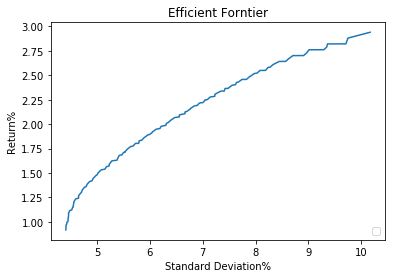

In [24]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(rr_df_new['risk'],rr_df_new['return'],label='')
plt.legend(loc="lower right")
plt.xlabel('Standard Deviation%')
plt.ylabel("Return%")
plt.title('Efficient Forntier')
plt.show()